In [1]:
import matplotlib.pyplot as plt
import numpy as np
from path import Path
import pickle
from prettytable import PrettyTable
from scipy.signal import argrelextrema, find_peaks
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 

In [2]:
# First run the test.py to create the results pickle file for analysis
architectures = ['cnn', 'fc', 'vit', 'rvit', 'rcnn']
datasets = ['chua', 'img2force', 'mixed']
features = ['random', 'stiffness']
data = ['rgb']
save_dir = Path('results')

In [3]:
# Load the data file or files
t_rmse = PrettyTable()
t_dtw = PrettyTable()
t_rmse.title = "Isolated feature RMSE (N)"
t_rmse.field_names = ["Models"] + ["{}".format(f) for f in features]
results = {}
for s in datasets:
    for d in data:
        for arch in architectures:
            shared_rmse_v, shared_rmse_s = [], []
            test_rmse_v, test_rmse_s = [], []
            for f in features:
                file_s = save_dir/"{}/{}/{}_state_{}.pkl".format(s, d, arch, f)
                with open(file_s, 'rb') as fileobject:
                    results_s = pickle.load(fileobject)       
                results["{}_{}_{}_state_{}".format(s, d, arch, f)] = results_s
                test_rmse_s.append(results_s['test_rmse'].mean())

            t_rmse.add_row(["{}_{}_{}_state".format(s, d, arch)] + ["{:.2f}".format(a) for a in test_rmse_s])

print(t_rmse)

+-----------------------------------------------+
|           Isolated feature RMSE (N)           |
+--------------------------+--------+-----------+
|          Models          | random | stiffness |
+--------------------------+--------+-----------+
|    chua_rgb_cnn_state    |  0.45  |    0.34   |
|    chua_rgb_fc_state     |  0.53  |    0.48   |
|    chua_rgb_vit_state    |  0.43  |    0.38   |
|   chua_rgb_rvit_state    |  0.14  |    0.09   |
|   chua_rgb_rcnn_state    |  0.15  |    0.13   |
| img2force_rgb_cnn_state  |  0.43  |    0.63   |
|  img2force_rgb_fc_state  |  0.39  |    0.51   |
| img2force_rgb_vit_state  |  0.76  |    0.52   |
| img2force_rgb_rvit_state |  0.43  |    0.36   |
| img2force_rgb_rcnn_state |  0.73  |    0.40   |
|   mixed_rgb_cnn_state    |  0.44  |    0.36   |
|    mixed_rgb_fc_state    |  0.54  |    0.44   |
|   mixed_rgb_vit_state    |  0.38  |    0.37   |
|   mixed_rgb_rvit_state   |  0.18  |    0.14   |
|   mixed_rgb_rcnn_state   |  0.18  |    0.11   |


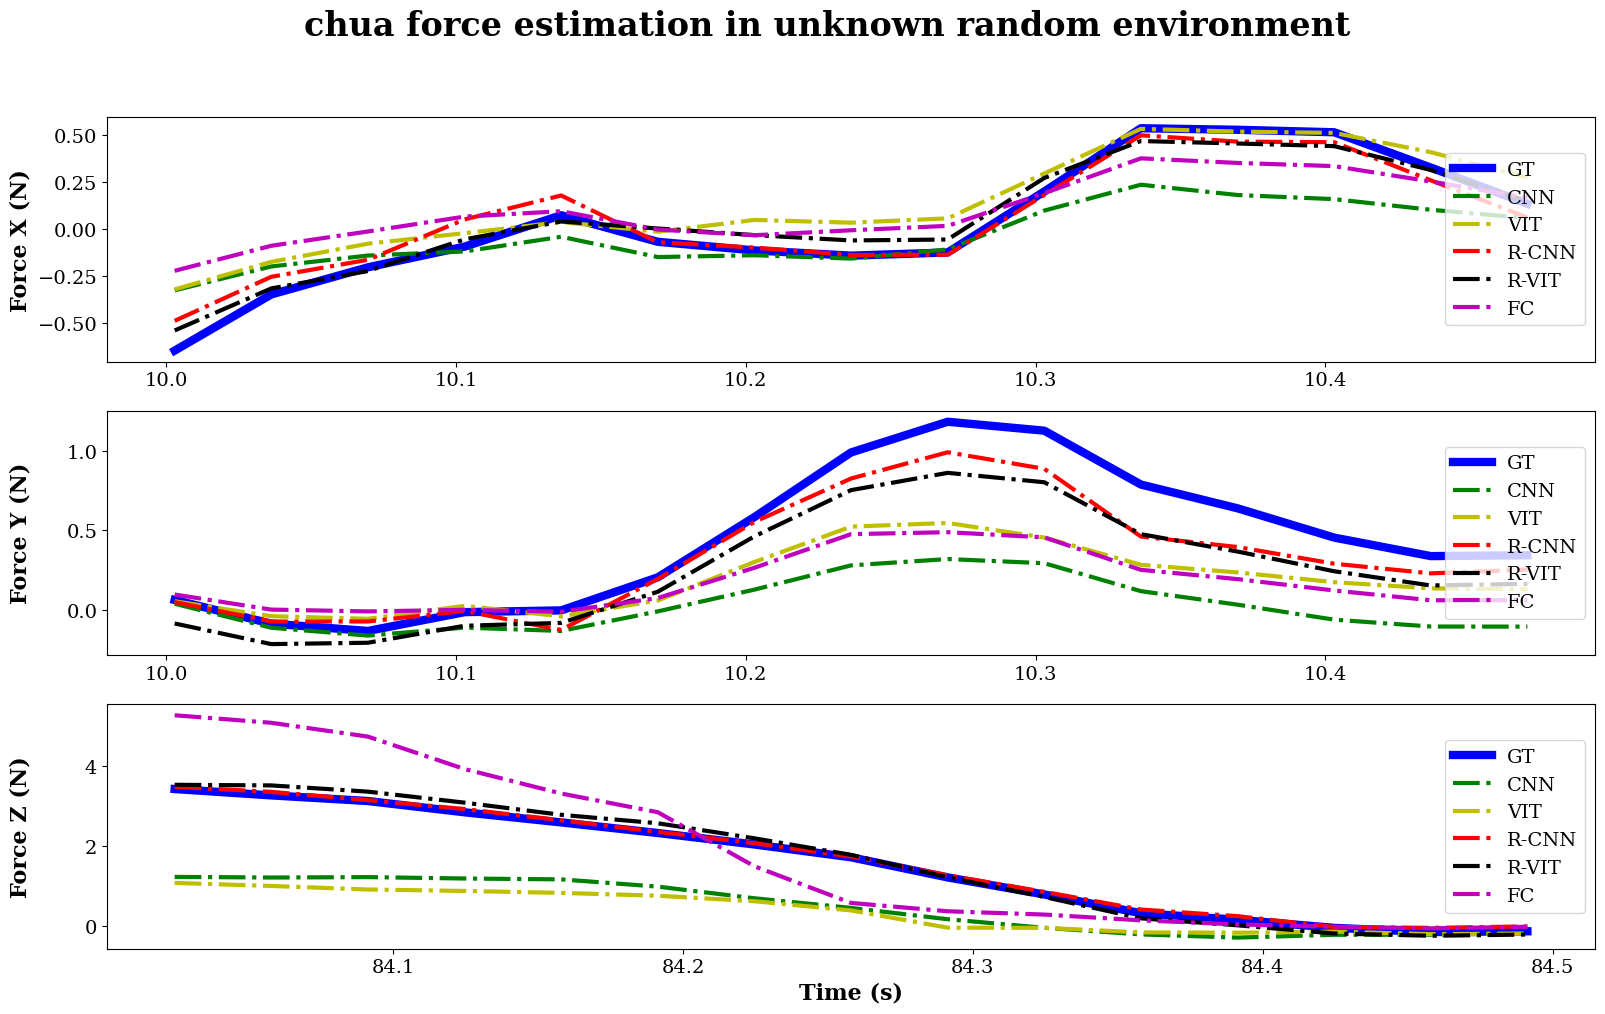

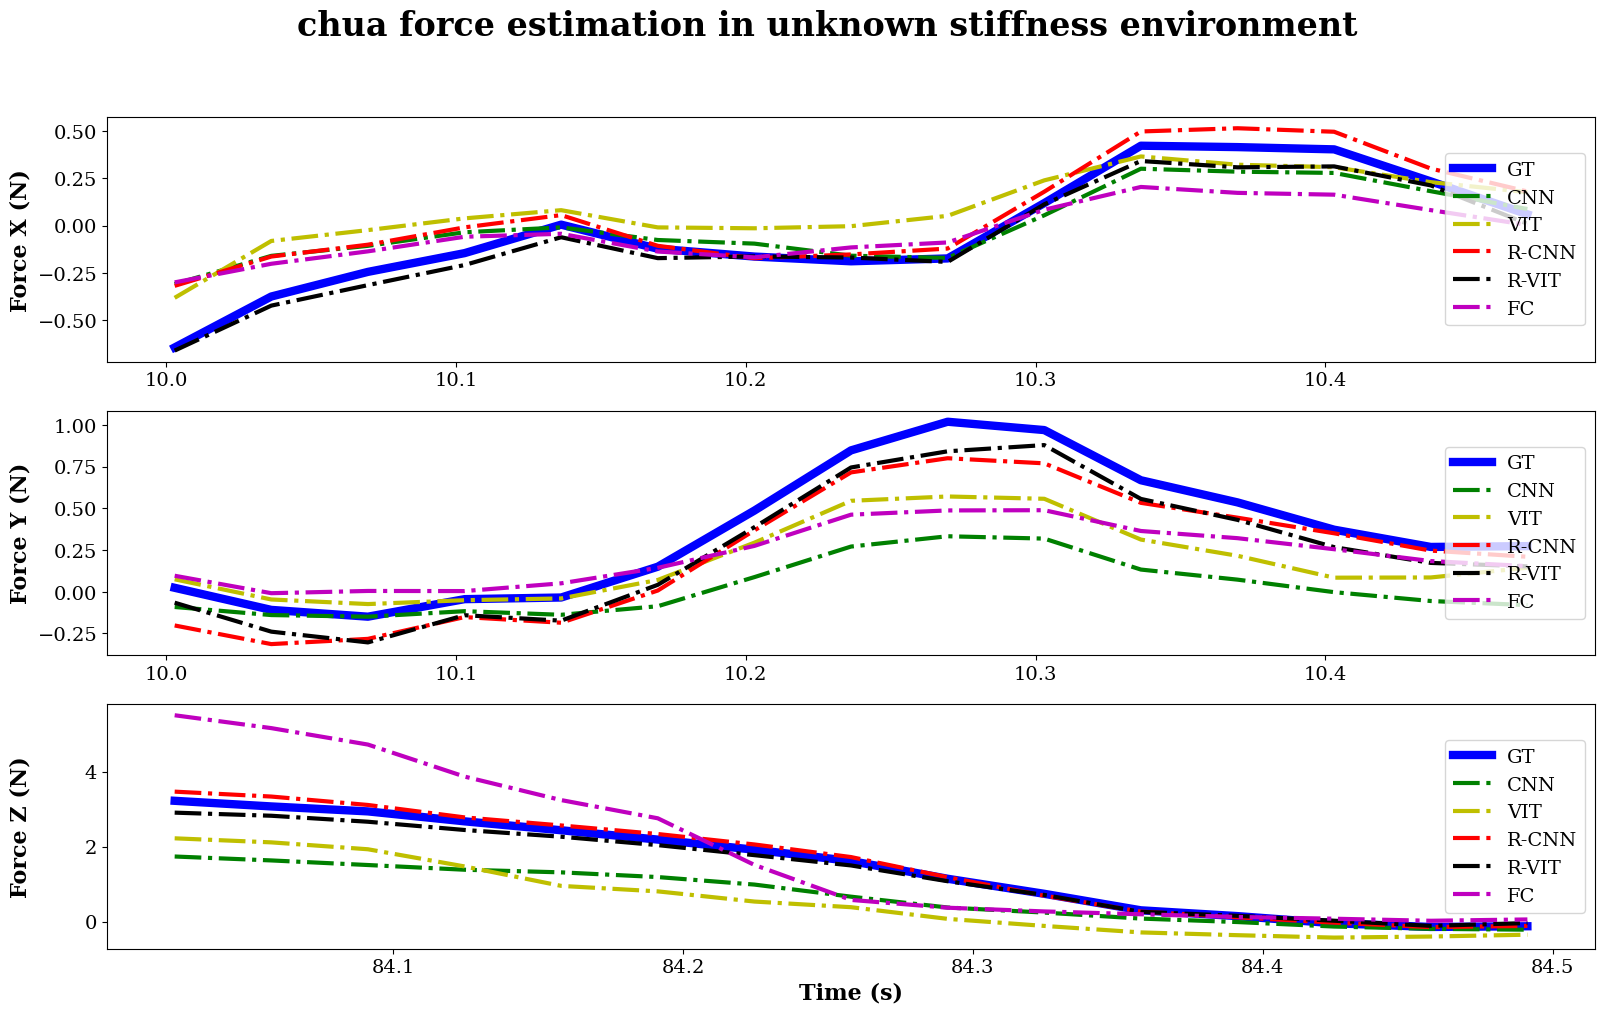

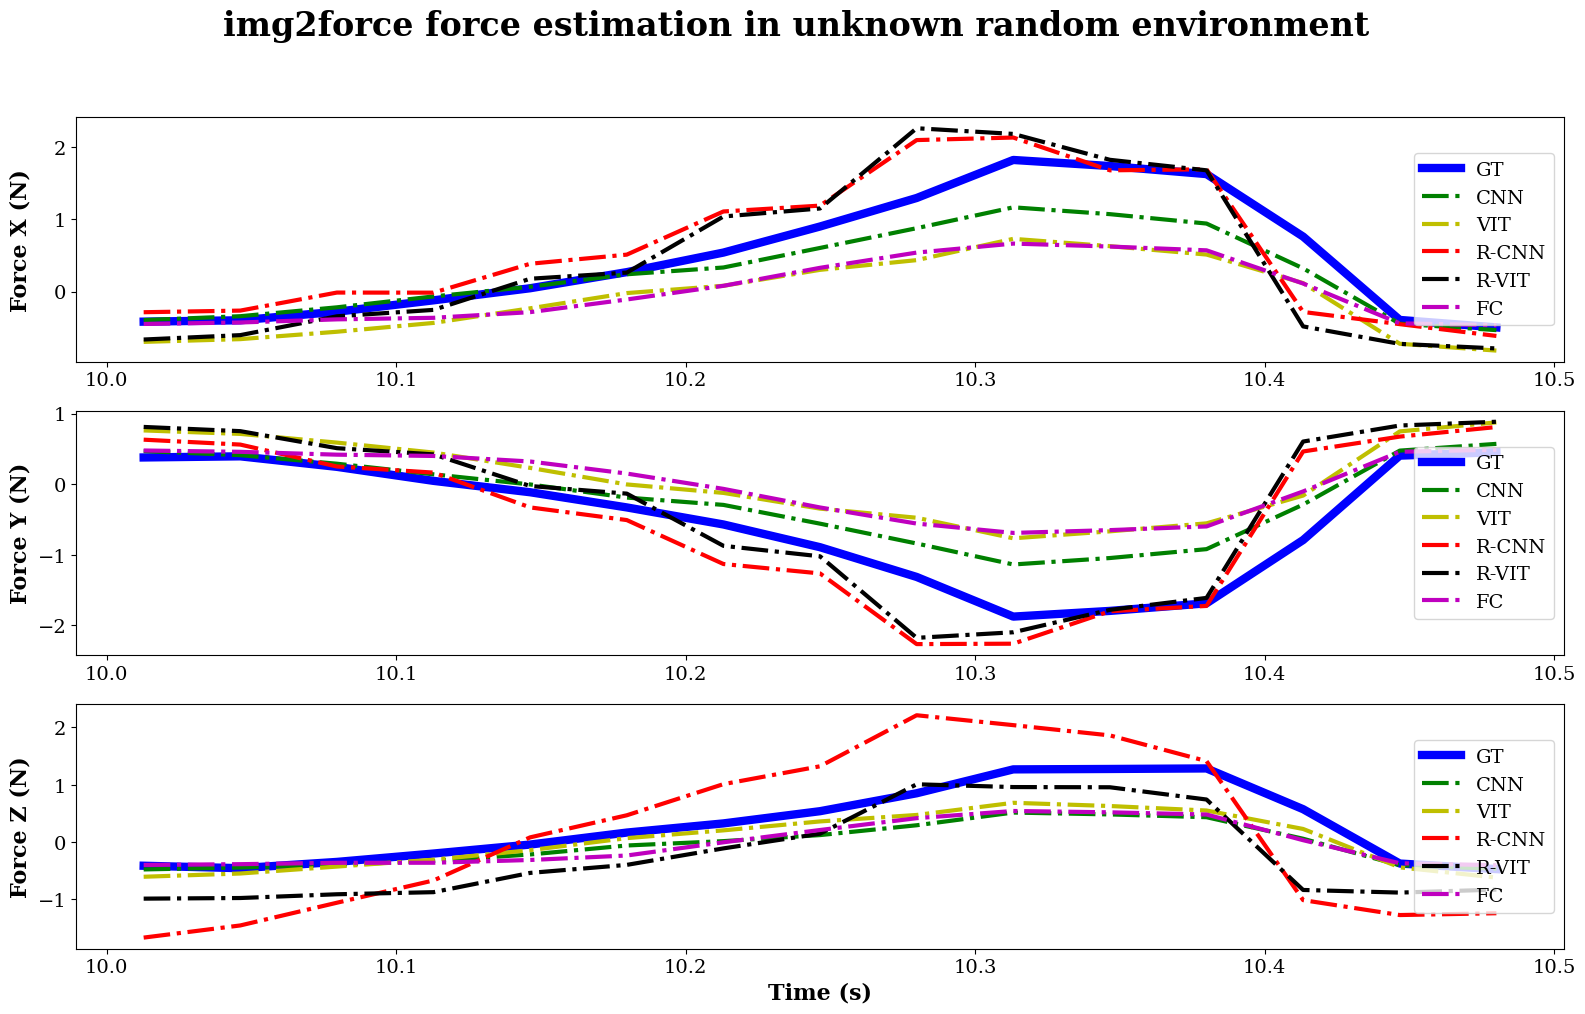

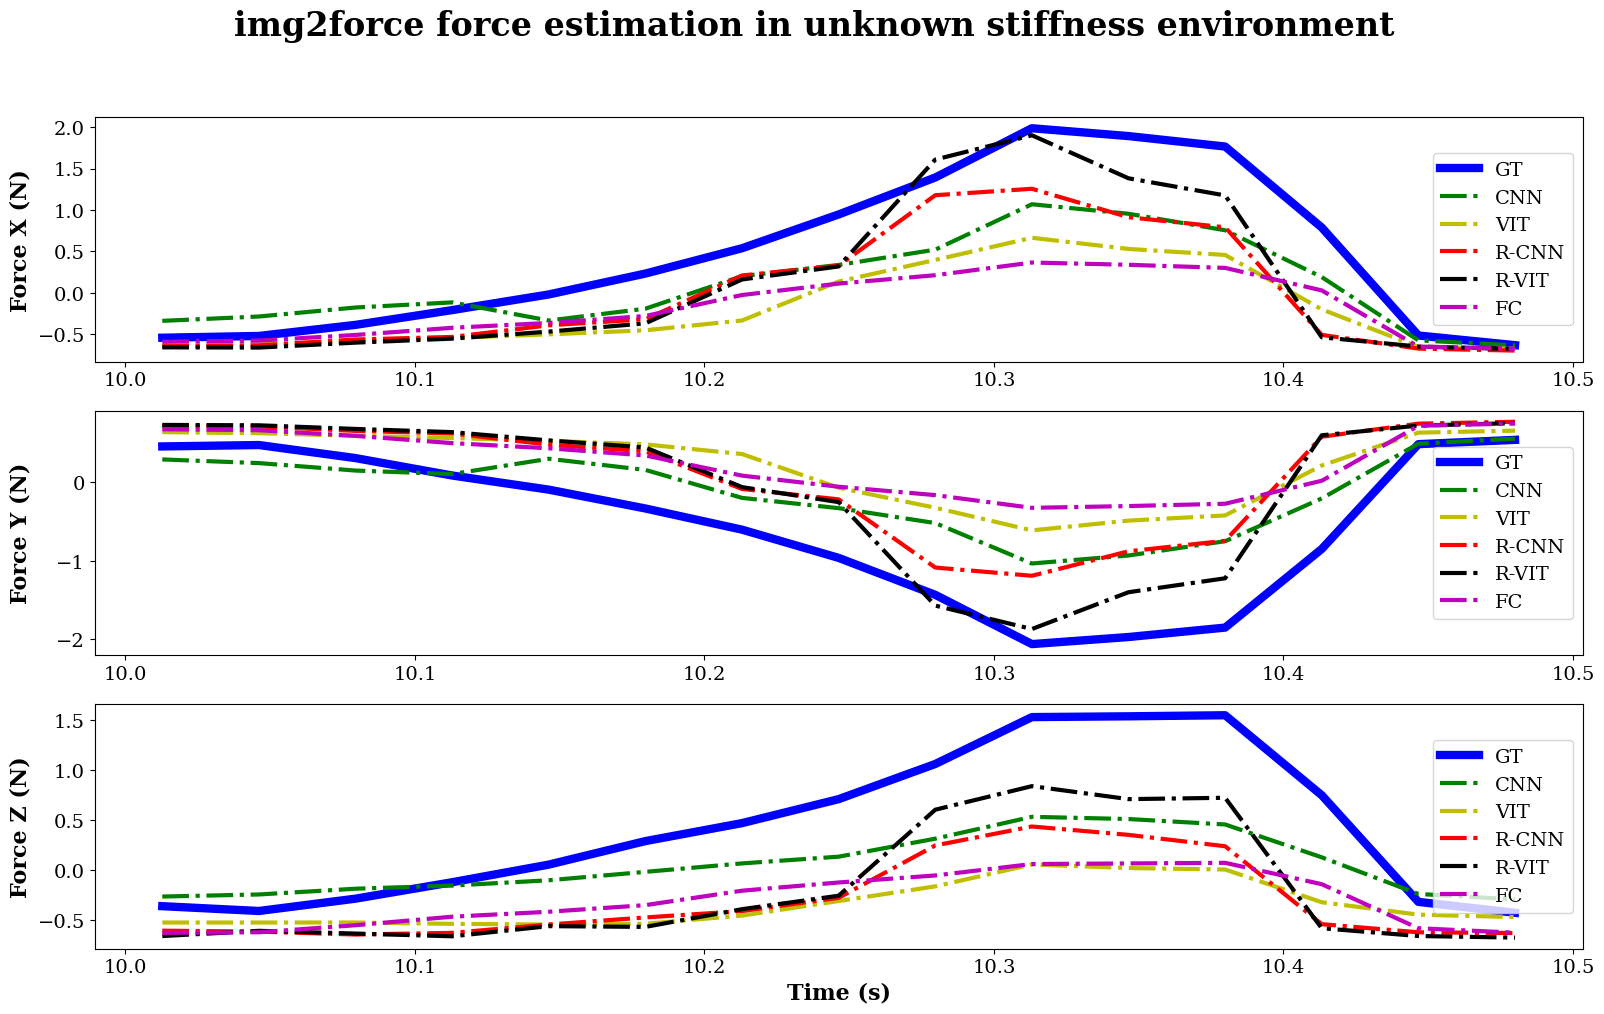

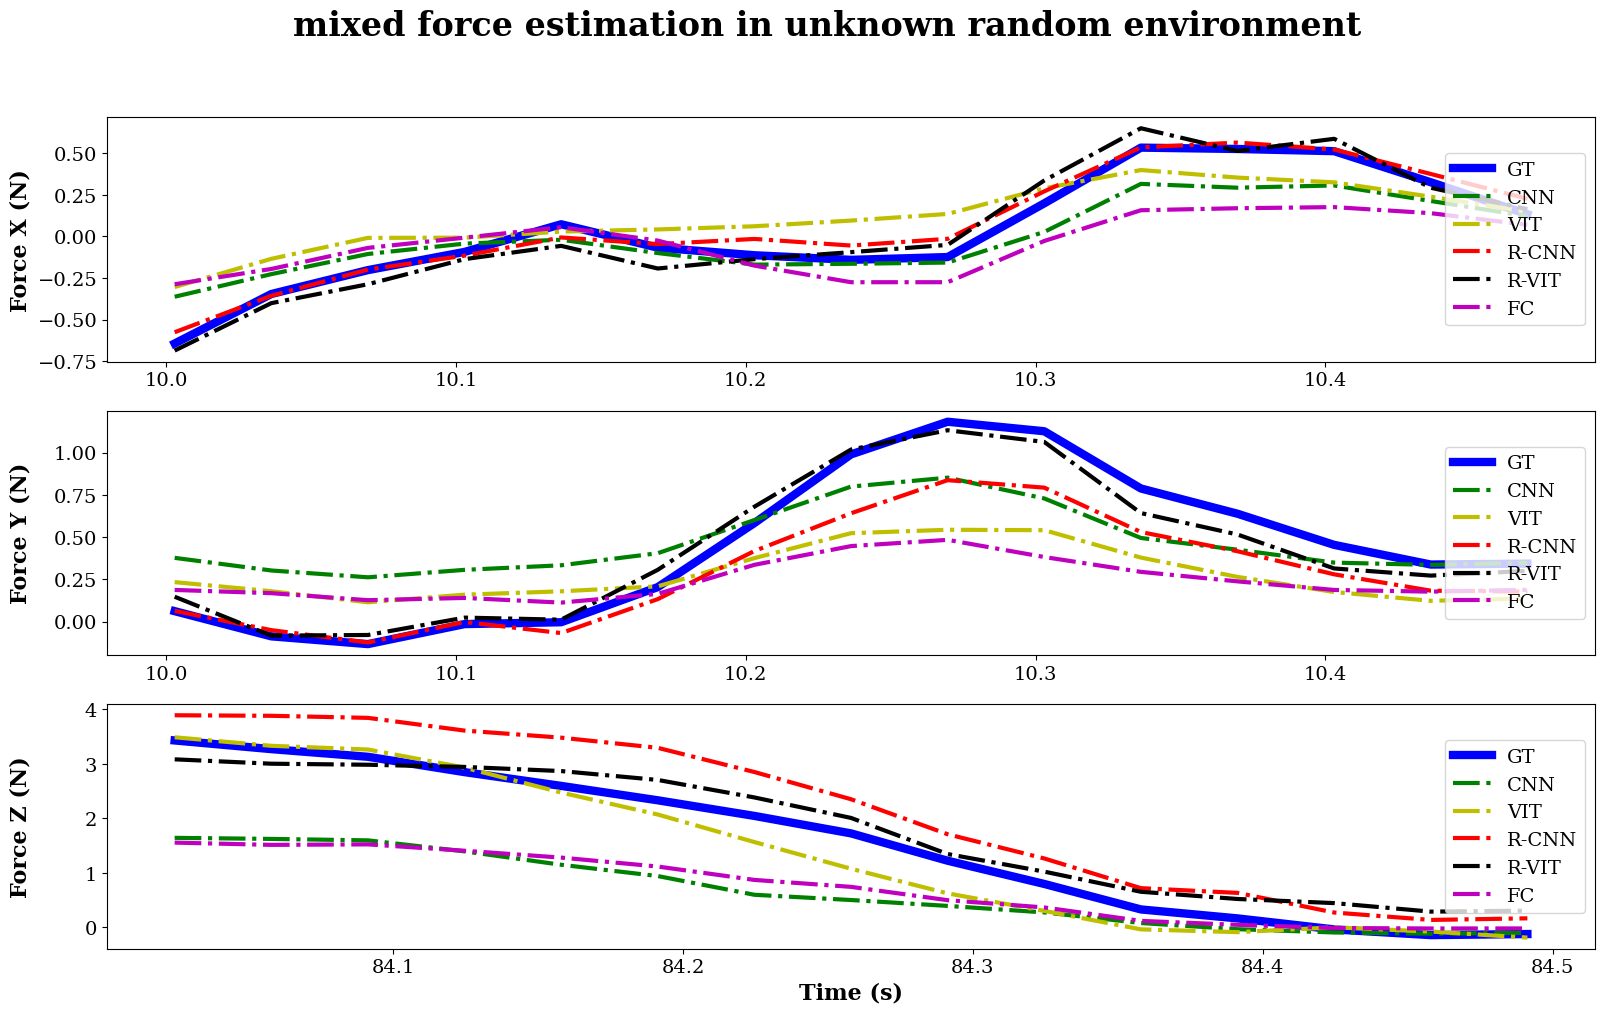

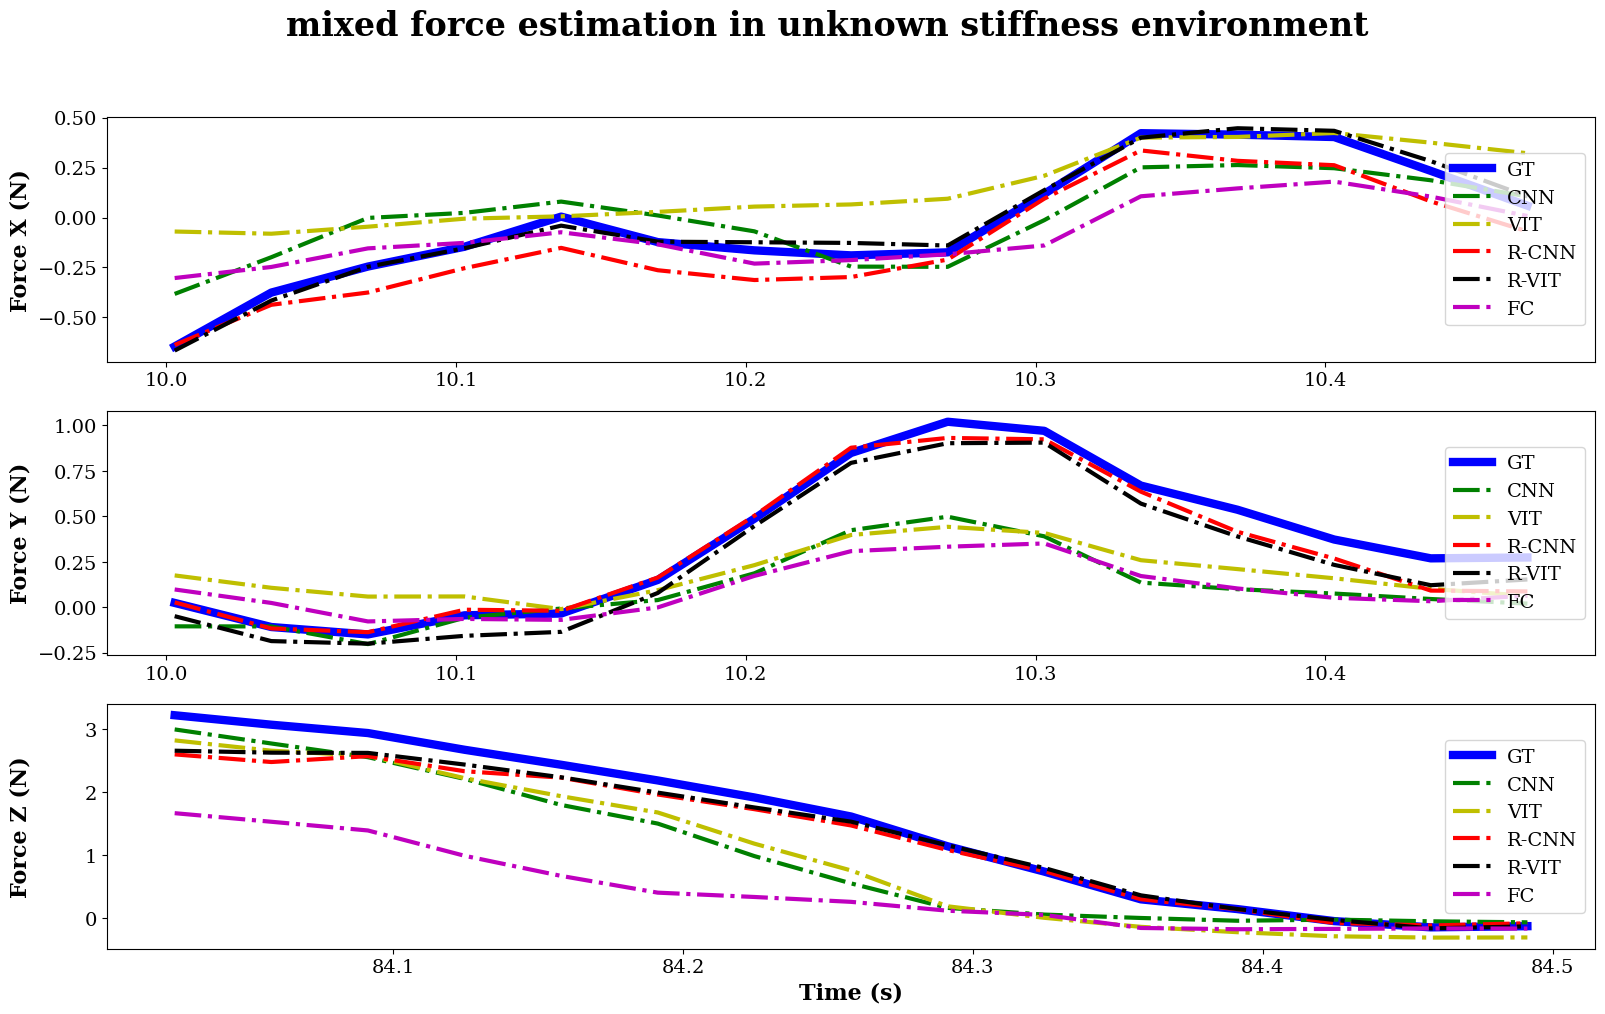

In [4]:
# Cell to plot the force estimation for the unseen testing set
my_dpi = 100
labels = ['X', 'Y', 'Z']
ranges = {"chua": [[30*10, int(30*10.5)], [30*10, int(30*10.5)], [30*84, int(30*84.5)]],
          "img2force": [[30*10, int(30*10.5)], [30*10, int(30*10.5)], [30*10, int(30*10.5)]],
          "mixed": [[30*10, int(30*10.5)], [30*10, int(30*10.5)], [30*84, int(30*84.5)]]}

save_fig_root = Path('figures')  
for s in datasets:
    x = (1/30)*np.linspace(0, len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']), len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']))
    x_rnn = (1/30)*np.linspace(0, len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']), len(results['{}_rgb_rcnn_state_random'.format(s)]['test_pred']))
    range_s = ranges[s]
    for f in features:
        for d in data:
            fig, axs = plt.subplots(ncols=1, nrows=3, sharex=False, sharey=False, figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
            fig.suptitle("{} force estimation in unknown {} environment".format(s, f), fontsize=24, fontweight='bold')
            for j, ax in enumerate(axs):
                r = range_s[j]
                rnn_range = [r[0], r[1]] if s=="img2force" else [r[0]-4, r[1]-4]
                ax.plot(x[r[0]:r[1]], results['{}_{}_cnn_state_{}'.format(s, d, f)]['test_gt'][r[0]:r[1], j], 'b', linewidth=6.0)
                ax.plot(x[r[0]:r[1]], results['{}_{}_cnn_state_{}'.format(s, d, f)]['test_pred'][r[0]:r[1], j], 'g-.', linewidth=3.0)
                ax.plot(x[r[0]:r[1]], results['{}_{}_vit_state_{}'.format(s, d, f)]['test_pred'][r[0]:r[1], j], 'y-.', linewidth=3.0)
                ax.plot(x[r[0]:r[1]], results['{}_{}_rcnn_state_{}'.format(s, d, f)]['test_pred'][rnn_range[0]:rnn_range[1], j], 'r-.', linewidth=3.0)
                ax.plot(x[r[0]:r[1]], results['{}_{}_rvit_state_{}'.format(s, d, f)]['test_pred'][rnn_range[0]:rnn_range[1], j], 'k-.', linewidth=3.0)
                ax.plot(x[r[0]:r[1]], results['{}_{}_fc_state_{}'.format(s, d, f)]['test_pred'][r[0]:r[1], j], 'm-.', linewidth=3.0)
                # ax.legend(["GT", "CNN", "CNN-BAM", "RNN", "RNN-BAM", 'FC'], fontsize=14)
                ax.legend(["GT", "CNN", "VIT", "R-CNN", "R-VIT", "FC"], fontsize=14, loc=5)
                ax.set_ylabel("Force {} (N)".format(labels[j]), fontsize=16, fontweight='bold')
                if j == 2:
                    ax.set_xlabel("Time (s)", fontsize=16, fontweight='bold')

            fig.align_labels()
            save_fig_path = save_fig_root/"{}".format(s)
            save_fig_path.makedirs_p()
            fig.savefig(save_fig_path/"{}.png".format(f), dpi=my_dpi)
            plt.show()

In [ ]:
my_dpi = 100
ranges = {"chua": [[30*10, 30*13], [30*10, 30*15], [30*84, 30*87]],
          "img2force": [[30*10, 30*13], [30*10, 30*15], [30*10, 30*15]],
          "mixed": [[30*10, 30*13], [30*10, 30*15], [30*84, 30*87]]}

for s in datasets:
    x = (1/30)*np.linspace(0, len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']), len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']))
    x_rnn = (1/30)*np.linspace(0, len(results['{}_rgb_cnn_state_random'.format(s)]['test_gt']), len(results['{}_rgb_rcnn_state_random'.format(s)]['test_pred']))
    range_s = ranges[s]
    for f in features:
        for d in data:
            r = range_s[j]
            fig, ax = plt.subplots(ncols=1, nrows=1, sharex=False, sharey=False, figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
            fig.suptitle("{} evolution of RMSE in unknown {} environment".format(s, f), fontsize=24, fontweight='bold')
            # ax.plot(x, results['{}_{}_cnn_state_{}'.format(s, d, f)]['test_gt'][r[0]:r[1], j], 'b', linewidth=3.0)
            ax.plot(x[r[0]:r[1]], results['{}_{}_cnn_state_{}'.format(s, d, f)]['test_rmse'][r[0]:r[1]], 'g', linewidth=3.0)
            ax.plot(x[r[0]:r[1]], results['{}_{}_vit_state_{}'.format(s, d, f)]['test_rmse'][r[0]:r[1]], 'y', linewidth=3.0)
            ax.plot(x[r[0]+4:r[1]+4], results['{}_{}_rcnn_state_{}'.format(s, d, f)]['test_rmse'][r[0]:r[1]], 'r', linewidth=3.0)
            ax.plot(x[r[0]+4:r[1]+4], results['{}_{}_rvit_state_{}'.format(s, d, f)]['test_rmse'][r[0]:r[1]], 'k', linewidth=3.0)
            ax.plot(x[r[0]:r[1]], results['{}_{}_fc_state_{}'.format(s, d, f)]['test_rmse'][r[0]:r[1]], 'm', linewidth=3.0)
            # ax.legend(["GT", "CNN", "CNN-BAM", "RNN", "RNN-BAM", 'FC'], fontsize=14)
            ax.legend(["CNN", "VIT", "R-CNN", "R-VIT", "FC"], fontsize=14, loc=1)
            ax.set_ylabel("RMSE (N)", fontsize=16, fontweight='bold')
            ax.set_xlabel("Time (s)", fontsize=16, fontweight='bold')
        
        save_fig_path = save_fig_root/"{}".format(s)
        save_fig_path.makedirs_p()
        fig.align_labels()
        fig.savefig(save_fig_path/'metrics_{}.png'.format(f), dpi=my_dpi)
        plt.show()

In [ ]:
fig = plt.figure()
for s in datasets:
    for d in data:
        for f in features:
            peaks_x, _ = find_peaks(results["{}_{}_cnn_state_{}".format(s, d, f)]["test_gt"][:, 0], distance=150)
            peaks_y, _ = find_peaks(results["{}_{}_cnn_state_{}".format(s, d, f)]["test_gt"][:, 1], distance=150)
            peaks_z, _ = find_peaks(results["{}_{}_cnn_state_{}".format(s, d, f)]["test_gt"][:, 2], distance=150)
            for arch in architectures:
                rmse_x = results["{}_{}_{}_state_{}".format(s, d, arch, f)]["test_rmse"][peaks_x].mean()
                rmse_y = results["{}_{}_{}_state_{}".format(s, d, arch, f)]["test_rmse"][peaks_y].mean()
                rmse_z = results["{}_{}_{}_state_{}".format(s, d, arch, f)]["test_rmse"][peaks_z].mean()
                langs = ["X", "Y", "Z"]
                rmse = np.mean([rmse_x, rmse_y, rmse_z])

                print("The value for {}_{}_{}_{}: {} N".format(s, d, arch, f, rmse))
                
                
